In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import required libraries
import opendatasets as od
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/punfake/resisc45'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'resisc45/NWPU-RESISC45'

# Load and preprocess dataset
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define Teacher Model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Define Student Model
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

input_shape = (32, 32, 3)
num_classes = len(lb.classes_)

teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Train Teacher
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Teacher Evaluation
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Distillation Loss Function (alpha=0.25)
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# Train Student
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Save trained models
teacher.save("teacher_model.h5")
student.save("student_model.h5")
print("Models saved successfully.")

# Evaluate Student on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# -----------------------------
# Robustness Evaluation Against Gaussian Noise
# -----------------------------

y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

# Lists to store results
stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list = []
y_reference_probs_list = []
y_pred_noisy_probs_list = []
y_pred_noisy_list = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    # Store predictions and references
    y_reference_list.append(y_reference)
    y_reference_probs_list.append(y_reference_probs)
    y_pred_noisy_probs_list.append(y_pred_noisy_probs)
    y_pred_noisy_list.append(y_pred_noisy)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshayanand2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/punfake/resisc45


100%|██████████| 407M/407M [00:00<00:00, 557MB/s]



Training samples: 25200, Testing samples: 6300
Epoch 1/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 264s 333ms/step - accuracy: 0.0502 - loss: 3.6674 - val_accuracy: 0.1814 - val_loss: 2.9417 - learning_rate: 0.0100
Epoch 2/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 257s 326ms/step - accuracy: 0.1857 - loss: 2.9250 - val_accuracy: 0.2960 - val_loss: 2.4944 - learning_rate: 0.0100
Epoch 3/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 265s 330ms/step - accuracy: 0.2896 - loss: 2.5039 - val_accuracy: 0.3449 - val_loss: 2.3025 - learning_rate: 0.0100
Epoch 4/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 265s 334ms/step - accuracy: 0.3627 - loss: 2.2133 - val_accuracy: 0.4248 - val_loss: 1.9693 - learning_rate: 0.0100
Epoch 5/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 317s 327ms/step - accuracy: 0.4369 - loss: 1.9422 - val_accuracy: 0.4924 - val_loss: 1.7410 - learning_rate: 0.0100
Epoch 6/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 275s 343ms/step - accuracy: 0.5058 - loss: 1.6892 - val_accuracy: 0.5379 - val_loss: 1.5593 - learning_rate: 0.0100
Epoch 7/15
788/7

Models saved successfully.
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                       precision    recall  f1-score   support

             airplane       0.72      0.65      0.69       136
              airport       0.50      0.44      0.47       142
     baseball_diamond       0.72      0.64      0.67       138
     basketball_court       0.37      0.34      0.35       135
                beach       0.80      0.76      0.78       153
               bridge       0.77      0.76      0.77       144
            chaparral       0.89      0.90      0.89       151
               church       0.52      0.46      0.49       142
    circular_farmland       0.71      0.76      0.74       127
                cloud       0.91      0.81      0.86       142
      commercial_area       0.41      0.56      0.47       124
    dense_residential       0.66      0.69      0.67       157
               desert       0.88      0.88      0.88 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.4032, F1 = 0.3813, Precision = 0.5687, Recall = 0.4032
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.16 -> Accuracy = 0.2279, F1 = 0.1952, Precision = 0.3906, Recall = 0.2279
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.1494, F1 = 0.1130, Precision = 0.2155, Recall = 0.1494
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.1130, F1 = 0.0756, Precision = 0.1513, Recall = 0.1130


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.0870, F1 = 0.0489, Precision = 0.1295, Recall = 0.0870
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.0733, F1 = 0.0352, Precision = 0.0765, Recall = 0.0733
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.0654, F1 = 0.0254, Precision = 0.0599, Recall = 0.0654
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.47 -> Accuracy = 0.0563, F1 = 0.0178, Precision = 0.0704, Recall = 0.0563
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.0525, F1 = 0.0141, Precision = 0.0465, Recall = 0.0525
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.0505, F1 = 0.0134, Precision = 0.0424, Recall = 0.0505
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0470, F1 = 0.0117, Precision = 0.0154, Recall = 0.0470


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0444, F1 = 0.0109, Precision = 0.0429, Recall = 0.0444
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.0424, F1 = 0.0113, Precision = 0.0405, Recall = 0.0424


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.79 -> Accuracy = 0.0392, F1 = 0.0084, Precision = 0.0270, Recall = 0.0392
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.0392, F1 = 0.0092, Precision = 0.0089, Recall = 0.0392
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.0359, F1 = 0.0093, Precision = 0.0144, Recall = 0.0359


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0351, F1 = 0.0076, Precision = 0.0084, Recall = 0.0351
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0370, F1 = 0.0090, Precision = 0.0088, Recall = 0.0370


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31])]
[array([[3.4806380e-08, 2.3389569e-08, 1.8244690e-10, ..., 4.0006900e-09,
        6.9476563e-08, 1.7251271e-10],
       [5.4229454e-10, 1.2614651e-04, 2.0166442e-06, ..., 1.6473685e-05,
        7.2868833e-10, 1.7315147e-08],
       [8.0468

In [3]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf

# Define distillation loss function if needed (dummy placeholder here)
def distillation_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Load models from .h5 files without compiling, then compile manually
teacher = tf.keras.models.load_model('teacher_model.h5', compile=False)
teacher.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

student = tf.keras.models.load_model('student_model.h5', compile=False)
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you already have preprocessed data ready in x_test and y_test
# If not, load your data here:
data_path = 'resisc45/NWPU-RESISC45'  # adjust path as needed
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Evaluate Teacher Model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Student Evaluation on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness Evaluation Against Gaussian Noise
y_reference_probs = student.predict(x_test)
y_reference = np.argmax(y_reference_probs, axis=1)

stddev_values = np.linspace(0, 1, 20)

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs = student.predict(x_noisy)
    y_pred_noisy = np.argmax(y_pred_noisy_probs, axis=1)

    acc = accuracy_score(y_reference, y_pred_noisy)
    f1 = f1_score(y_reference, y_pred_noisy, average='weighted')
    precision = precision_score(y_reference, y_pred_noisy, average='weighted')
    recall = recall_score(y_reference, y_pred_noisy, average='weighted')

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Teacher test accuracy: 65.21%
788/788 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                       precision    recall  f1-score   support

             airplane       0.72      0.65      0.69       136
              airport       0.50      0.44      0.47       142
     baseball_diamond       0.72      0.64      0.67       138
     basketball_court       0.37      0.34      0.35       135
                beach       0.80      0.76      0.78       153
               bridge       0.77      0.76      0.77       144
            chaparral       0.89      0.90      0.89       151
               church       0.52      0.46      0.49       142
    circular_farmland       0.71      0.76      0.74       127
                cloud       0.91      0.81      0.86       142
      commercial_area       0.41      0.56      0.47       124
    dense_residential       0.66      0.69      0.67       157
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.16 -> Accuracy = 0.2294, F1 = 0.1944, Precision = 0.3862, Recall = 0.2294
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.1478, F1 = 0.1128, Precision = 0.2798, Recall = 0.1478


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.1092, F1 = 0.0729, Precision = 0.1662, Recall = 0.1092
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.0846, F1 = 0.0466, Precision = 0.1208, Recall = 0.0846


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.0719, F1 = 0.0324, Precision = 0.0844, Recall = 0.0719


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.0633, F1 = 0.0240, Precision = 0.0620, Recall = 0.0633


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.0563, F1 = 0.0179, Precision = 0.0622, Recall = 0.0563


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.0500, F1 = 0.0134, Precision = 0.0825, Recall = 0.0500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.0492, F1 = 0.0138, Precision = 0.0586, Recall = 0.0492


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.0460, F1 = 0.0113, Precision = 0.0173, Recall = 0.0460
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0437, F1 = 0.0100, Precision = 0.0085, Recall = 0.0437
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.74 -> Accuracy = 0.0419, F1 = 0.0098, Precision = 0.0192, Recall = 0.0419


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.79 -> Accuracy = 0.0384, F1 = 0.0090, Precision = 0.0071, Recall = 0.0384
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.0425, F1 = 0.0104, Precision = 0.0089, Recall = 0.0425
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Noise STDDEV = 0.89 -> Accuracy = 0.0349, F1 = 0.0067, Precision = 0.0051, Recall = 0.0349


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0387, F1 = 0.0082, Precision = 0.0073, Recall = 0.0387
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0363, F1 = 0.0095, Precision = 0.0173, Recall = 0.0363


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31])]
[array([[3.4806380e-08, 2.3389569e-08, 1.8244690e-10, ..., 4.0006900e-09,
        6.9476563e-08, 1.7251271e-10],
       [5.4229454e-10, 1.2614651e-04, 2.0166442e-06, ..., 1.6473685e-05,
        7.2868833e-10, 1.7315147e-08],
       [8.0468

In [5]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import required libraries
import opendatasets as od
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/punfake/resisc45'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'resisc45/NWPU-RESISC45'

# Load and preprocess dataset
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define Teacher Model
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Define Student Model
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

input_shape = (32, 32, 3)
num_classes = len(lb.classes_)

teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Train Teacher
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])


Skipping, found downloaded files in "./resisc45" (use force=True to force download)
Training samples: 25200, Testing samples: 6300
Epoch 1/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 264s 333ms/step - accuracy: 0.0457 - loss: 3.6783 - val_accuracy: 0.1784 - val_loss: 2.9828 - learning_rate: 0.0100
Epoch 2/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 320s 330ms/step - accuracy: 0.1862 - loss: 2.9535 - val_accuracy: 0.3165 - val_loss: 2.3882 - learning_rate: 0.0100
Epoch 3/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 270s 340ms/step - accuracy: 0.2886 - loss: 2.5048 - val_accuracy: 0.3773 - val_loss: 2.1721 - learning_rate: 0.0100
Epoch 4/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 318s 335ms/step - accuracy: 0.3671 - loss: 2.1898 - val_accuracy: 0.4724 - val_loss: 1.8319 - learning_rate: 0.0100
Epoch 5/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 321s 333ms/step - accuracy: 0.4493 - loss: 1.8924 - val_accuracy: 0.5124 - val_loss: 1.6921 - learning_rate: 0.0100
Epoch 6/15
788/788 ━━━━━━━━━━━━━━━━━━━━ 323s 335ms/step - accuracy: 0.5066 - loss: 1.6708

In [6]:

# Teacher Evaluation
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Teacher predictions (for distillation)
teacher_preds = teacher.predict(x_train)

# Distillation Loss Function with Nuclear Norm (alpha=0.25)
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)

    first_layer_weights = None
    for layer in student.layers:
      if layer.weights:
        first_layer_weights = layer.weights[0]
        break
      if first_layer_weights is not None:
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
      else:
        nuclear_norm = 0.
    return alpha * (soft_loss + 0.001 * nuclear_norm) + (1. - alpha) * hard_loss

# Train Student
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
    metrics=['accuracy']
)
student.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Save trained models
teacher.save("teacher_model_1.h5")
student.save("student_model_1.h5")
print("Models saved successfully.")

# Evaluate Student on Clean Test Set
start_time = time.time()
y_pred_probs = student.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# -----------------------------
# Robustness Evaluation Against Gaussian Noise
# -----------------------------
y_reference_probs_1 = student.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student.predict(x_noisy)
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

Teacher test accuracy: 64.03%
788/788 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step
Epoch 1/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - accuracy: 0.0399 - loss: 3.8067 - val_accuracy: 0.1367 - val_loss: 3.8066 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.1507 - loss: 3.8066 - val_accuracy: 0.2603 - val_loss: 3.8065 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.2346 - loss: 3.8066 - val_accuracy: 0.3297 - val_loss: 3.8065 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.3145 - loss: 3.8065 - val_accuracy: 0.4070 - val_loss: 3.8064 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.3714 - loss: 3.8065 - val_accuracy: 0.4214 - val_loss: 3.8064 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.4192 - loss: 3.8064 - val_accuracy: 0.4635 - val_loss: 3.8064 - learning_rate: 0.0010
Epo

Models saved successfully.
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

=== Final Student Model Evaluation on Clean Test Set ===
                       precision    recall  f1-score   support

             airplane       0.67      0.69      0.68       136
              airport       0.36      0.46      0.40       142
     baseball_diamond       0.72      0.62      0.67       138
     basketball_court       0.38      0.34      0.36       135
                beach       0.83      0.86      0.85       153
               bridge       0.86      0.71      0.78       144
            chaparral       0.93      0.89      0.91       151
               church       0.58      0.49      0.53       142
    circular_farmland       0.69      0.74      0.71       127
                cloud       0.80      0.80      0.80       142
      commercial_area       0.43      0.58      0.50       124
    dense_residential       0.74      0.67      0.70       157
               desert       0.89      0.87      0.88 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.2044, F1 = 0.1833, Precision = 0.3789, Recall = 0.2044


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.1152, F1 = 0.0890, Precision = 0.2663, Recall = 0.1152


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.26 -> Accuracy = 0.0822, F1 = 0.0502, Precision = 0.1945, Recall = 0.0822


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.0605, F1 = 0.0287, Precision = 0.1103, Recall = 0.0605


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.0535, F1 = 0.0193, Precision = 0.0726, Recall = 0.0535


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.0459, F1 = 0.0128, Precision = 0.0392, Recall = 0.0459
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Noise STDDEV = 0.47 -> Accuracy = 0.0429, F1 = 0.0101, Precision = 0.0576, Recall = 0.0429


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.0432, F1 = 0.0096, Precision = 0.0146, Recall = 0.0432


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.58 -> Accuracy = 0.0405, F1 = 0.0095, Precision = 0.0236, Recall = 0.0405
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.63 -> Accuracy = 0.0381, F1 = 0.0081, Precision = 0.0187, Recall = 0.0381
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0333, F1 = 0.0057, Precision = 0.0034, Recall = 0.0333
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0316, F1 = 0.0060, Precision = 0.0172, Recall = 0.0316
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0322, F1 = 0.0058, Precision = 0.0060, Recall = 0.0322


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Noise STDDEV = 0.84 -> Accuracy = 0.0319, F1 = 0.0062, Precision = 0.0061, Recall = 0.0319


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.0276, F1 = 0.0048, Precision = 0.0029, Recall = 0.0276
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0279, F1 = 0.0056, Precision = 0.0113, Recall = 0.0279
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0305, F1 = 0.0055, Precision = 0.0058, Recall = 0.0305


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
print(y_reference_list_1)
print(y_reference_probs_list_1)
print(y_pred_noisy_probs_list_1)
print(y_pred_noisy_list_1)

[array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31])]
[array([[1.0094900e-06, 1.4481078e-07, 6.5195217e-11, ..., 2.5325328e-14,
        6.1504426e-07, 8.1687613e-13],
       [9.0556007e-08, 1.2392967e-03, 1.2986436e-03, ..., 6.3722447e-04,
        4.1705888e-09, 3.3893360e-07],
       [8.7681

In [9]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import tensorflow as tf
from keras.callbacks import LearningRateScheduler

# Load models from .h5 files without compiling
teacher_1 = tf.keras.models.load_model('teacher_model_1.h5', compile=False)
student_1 = tf.keras.models.load_model('student_model_1.h5', compile=False)

# Load and preprocess data
data_path = 'resisc45/NWPU-RESISC45'
image_data = []
labels = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))
            image = img_to_array(image)
            image_data.append(image)
            label = root.split(os.path.sep)[-1]
            labels.append(label)

image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Get teacher predictions for distillation
teacher_preds_1 = teacher_1.predict(x_train)

# Define distillation loss function with nuclear norm
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.25):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true_soft = tf.keras.activations.softmax(y_true / temperature)
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_soft, y_pred_soft)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)

    first_layer_weights = None
    for layer in student_1.layers:
        if layer.weights:
            first_layer_weights = layer.weights[0]
            break

    if first_layer_weights is not None:
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        nuclear_norm = 0.

    return alpha * (soft_loss + 0.001 * nuclear_norm) + (1. - alpha) * hard_loss

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile student model with custom loss
student_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds_1),
    metrics=['accuracy']
)

# Retrain student model (if needed)
student_1.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate student on clean test set
start_time = time.time()
y_pred_probs = student_1.predict(x_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n=== Final Student Model Evaluation on Clean Test Set ===")
print(classification_report(y_true, y_pred, target_names=lb.classes_))
print(f"Inference Time: {inference_time:.4f} seconds")

# Robustness evaluation
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

# stddev_values = np.linspace(0, 1, 20)

# for stddev in stddev_values:
#     noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
#     x_noisy = np.clip(x_test + noise, 0., 1.)

#     y_pred_noisy_probs_1 = student_1.predict(x_noisy)
#     y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

#     acc = accuracy_score(y_reference_1, y_pred_noisy_1)
#     f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
#     recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

#     print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy) ########
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")
# print(y_reference_list_1)
# print(y_reference_probs_list_1)
# print(y_pred_noisy_probs_list_1)
# print(y_pred_noisy_list_1)

788/788 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step
Epoch 1/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 66s 81ms/step - accuracy: 0.7387 - loss: 3.8091 - val_accuracy: 0.4352 - val_loss: 3.8069 - learning_rate: 0.0010
Epoch 2/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.5121 - loss: 3.8067 - val_accuracy: 0.5043 - val_loss: 3.8066 - learning_rate: 0.0010
Epoch 3/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.5090 - loss: 3.8066 - val_accuracy: 0.4743 - val_loss: 3.8065 - learning_rate: 0.0010
Epoch 4/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.5203 - loss: 3.8065 - val_accuracy: 0.4994 - val_loss: 3.8065 - learning_rate: 0.0010
Epoch 5/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.5419 - loss: 3.8065 - val_accuracy: 0.4165 - val_loss: 3.8066 - learning_rate: 0.0010
Epoch 6/30
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.5419 - loss: 3.8065 - val_accuracy: 0.5425 - val_loss: 3.8064 - learning_rate: 0.0010
Epoch 7/30
788/788 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.3711, F1 = 0.3496, Precision = 0.5416, Recall = 0.3711
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.16 -> Accuracy = 0.1697, F1 = 0.1547, Precision = 0.3392, Recall = 0.1697


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.21 -> Accuracy = 0.0956, F1 = 0.0657, Precision = 0.2049, Recall = 0.0956


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.0721, F1 = 0.0391, Precision = 0.1173, Recall = 0.0721
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.32 -> Accuracy = 0.0576, F1 = 0.0212, Precision = 0.0722, Recall = 0.0576


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.37 -> Accuracy = 0.0527, F1 = 0.0153, Precision = 0.0330, Recall = 0.0527
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.42 -> Accuracy = 0.0505, F1 = 0.0140, Precision = 0.0517, Recall = 0.0505


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.47 -> Accuracy = 0.0462, F1 = 0.0114, Precision = 0.0132, Recall = 0.0462
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.53 -> Accuracy = 0.0427, F1 = 0.0100, Precision = 0.0071, Recall = 0.0427
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.0440, F1 = 0.0100, Precision = 0.0115, Recall = 0.0440


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0444, F1 = 0.0095, Precision = 0.0059, Recall = 0.0444


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.68 -> Accuracy = 0.0452, F1 = 0.0093, Precision = 0.0084, Recall = 0.0452
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0430, F1 = 0.0083, Precision = 0.0048, Recall = 0.0430
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.79 -> Accuracy = 0.0417, F1 = 0.0077, Precision = 0.0044, Recall = 0.0417


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Noise STDDEV = 0.84 -> Accuracy = 0.0410, F1 = 0.0077, Precision = 0.0045, Recall = 0.0410


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.0387, F1 = 0.0070, Precision = 0.0044, Recall = 0.0387
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0402, F1 = 0.0073, Precision = 0.0136, Recall = 0.0402
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0410, F1 = 0.0070, Precision = 0.0042, Recall = 0.0410


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
y_reference_probs_1 = student_1.predict(x_test)
y_reference_1 = np.argmax(y_reference_probs_1, axis=1)

stddev_values = np.linspace(0, 1, 20)
noisy_accuracies, noisy_f1_scores, noisy_precisions, noisy_recalls = [], [], [], []
y_reference_list_1 = []
y_reference_probs_list_1 = []
y_pred_noisy_probs_list_1 = []
y_pred_noisy_list_1 = []

for stddev in stddev_values:
    noise = np.random.normal(loc=0.0, scale=stddev, size=x_test.shape)
    x_noisy = np.clip(x_test + noise, 0., 1.)

    y_pred_noisy_probs_1 = student_1.predict(x_noisy)
    y_pred_noisy_1 = np.argmax(y_pred_noisy_probs_1, axis=1)

    acc = accuracy_score(y_reference_1, y_pred_noisy_1)
    f1 = f1_score(y_reference_1, y_pred_noisy_1, average='weighted')
    precision = precision_score(y_reference_1, y_pred_noisy_1, average='weighted')
    recall = recall_score(y_reference_1, y_pred_noisy_1, average='weighted')

    noisy_accuracies.append(acc)
    noisy_f1_scores.append(f1)
    noisy_precisions.append(precision)
    noisy_recalls.append(recall)

    y_reference_list_1.append(y_reference_1)
    y_reference_probs_list_1.append(y_reference_probs_1)
    y_pred_noisy_probs_list_1.append(y_pred_noisy_probs_1)
    y_pred_noisy_list_1.append(y_pred_noisy_1)

    print(f"Noise STDDEV = {stddev:.2f} -> Accuracy = {acc:.4f}, F1 = {f1:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.00 -> Accuracy = 1.0000, F1 = 1.0000, Precision = 1.0000, Recall = 1.0000
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.05 -> Accuracy = 0.6954, F1 = 0.6909, Precision = 0.7515, Recall = 0.6954
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.11 -> Accuracy = 0.3692, F1 = 0.3473, Precision = 0.5328, Recall = 0.3692
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.16 -> Accuracy = 0.1792, F1 = 0.1636, Precision = 0.3531, Recall = 0.1792
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.21 -> Accuracy = 0.0968, F1 = 0.0690, Precision = 0.2131, Recall = 0.0968
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.26 -> Accuracy = 0.0694, F1 = 0.0359, Precision = 0.1105, Recall = 0.0694
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.32 -> Accuracy = 0.0575, F1 = 0.0226, Precision = 0.1119, Recall = 0.0575
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.37 -> Accuracy = 0.0540, F1 = 0.0182, Precision = 0.0721, Recall = 0.0540


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.42 -> Accuracy = 0.0498, F1 = 0.0135, Precision = 0.0302, Recall = 0.0498
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.47 -> Accuracy = 0.0468, F1 = 0.0115, Precision = 0.0080, Recall = 0.0468
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.53 -> Accuracy = 0.0454, F1 = 0.0106, Precision = 0.0067, Recall = 0.0454


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Noise STDDEV = 0.58 -> Accuracy = 0.0440, F1 = 0.0097, Precision = 0.0059, Recall = 0.0440


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Noise STDDEV = 0.63 -> Accuracy = 0.0443, F1 = 0.0099, Precision = 0.0070, Recall = 0.0443


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
Noise STDDEV = 0.68 -> Accuracy = 0.0429, F1 = 0.0085, Precision = 0.0050, Recall = 0.0429


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.74 -> Accuracy = 0.0421, F1 = 0.0088, Precision = 0.0055, Recall = 0.0421
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.79 -> Accuracy = 0.0413, F1 = 0.0076, Precision = 0.0043, Recall = 0.0413
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.84 -> Accuracy = 0.0414, F1 = 0.0081, Precision = 0.0059, Recall = 0.0414
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.89 -> Accuracy = 0.0406, F1 = 0.0077, Precision = 0.0054, Recall = 0.0406
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Noise STDDEV = 0.95 -> Accuracy = 0.0410, F1 = 0.0074, Precision = 0.0052, Recall = 0.0410
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Noise STDDEV = 1.00 -> Accuracy = 0.0378, F1 = 0.0061, Precision = 0.0036, Recall = 0.0378


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
print(y_reference_list_1)
print(y_reference_probs_list_1)
print(y_pred_noisy_probs_list_1)
print(y_pred_noisy_list_1)

[array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31])]
[array([[1.51810245e-05, 8.75215335e-07, 1.81251579e-07, ...,
        7.50473739e-10, 1.42527415e-05, 8.33124076e-08],
       [2.38019356e-06, 9.70170193e-04, 2.05211749e-04, ...,
        3.10381030e-04, 4.41448371e-08, 8.57553530e-08],
  

In [12]:
print(y_reference_list)
print(y_reference_probs_list)
print(y_pred_noisy_probs_list)
print(y_pred_noisy_list)

[array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31]), array([17,  8,  0, ..., 13, 21, 31])]
[array([[3.4806380e-08, 2.3389569e-08, 1.8244690e-10, ..., 4.0006900e-09,
        6.9476563e-08, 1.7251271e-10],
       [5.4229454e-10, 1.2614651e-04, 2.0166442e-06, ..., 1.6473685e-05,
        7.2868833e-10, 1.7315147e-08],
       [8.0468

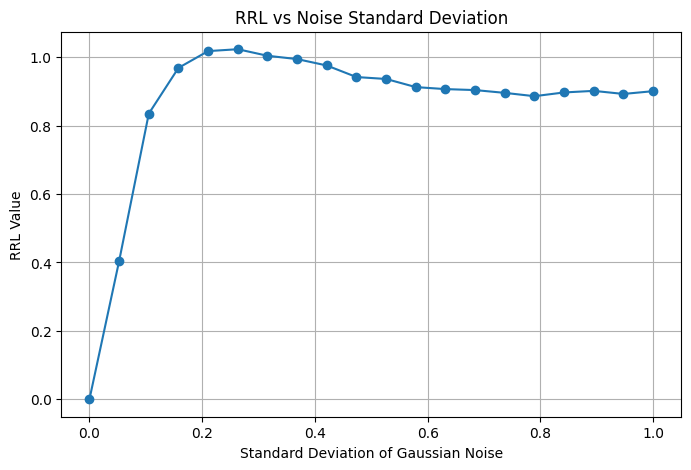

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
fig = plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)

# Save the figure as PDF before showing
fig.savefig('rrl_vs_noise_NWPU.pdf')

# Show the plot
plt.show()


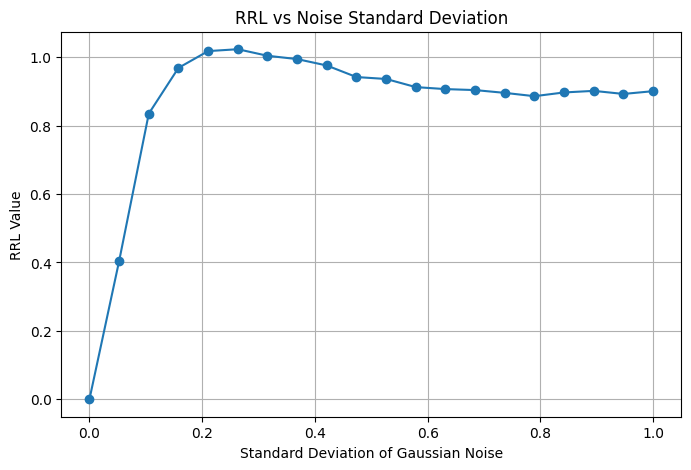

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1 (all lists of arrays of shape (samples, num_classes))
# and stddev_values (length 20)

rrl_values = []

for pred_noisy_1, pred_noisy, ref_probs in zip(y_pred_noisy_probs_list_1, y_pred_noisy_probs_list, y_reference_probs_list_1):
    # Compute numerator: l2 norm squared between pred_noisy_1 and ref_probs
    numerator = np.linalg.norm(pred_noisy_1 - ref_probs) ** 2

    # Compute denominator: l2 norm squared between pred_noisy and ref_probs
    denominator = np.linalg.norm(pred_noisy - ref_probs) ** 2

    # Compute RRL value
    rrl = numerator / denominator if denominator != 0 else np.nan
    rrl_values.append(rrl)

# Plot RRL vs Standard Deviation
plt.figure(figsize=(8, 5))
plt.plot(stddev_values, rrl_values, marker='o')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('RRL Value')
plt.title('RRL vs Noise Standard Deviation')
plt.grid(True)
plt.show()